<a href="https://colab.research.google.com/github/GoYejin87/Generate_Talking_Emoji/blob/main/SIFT%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%9D%B4%EB%AF%B8%EC%A7%80%EC%A0%95%EB%A0%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIFT (Scale-Invariant Feature Transform)

keypoint: 1120 descriptor: (1120, 128)
[[ 0.  0.  0. ... 10. 10.  4.]
 [ 0.  0.  0. ...  0.  1.  2.]
 [ 1.  0.  0. ... 80. 66.  4.]
 ...
 [ 6. 14. 64. ...  8. 10.  7.]
 [ 2. 18. 80. ...  1.  0.  1.]
 [28. 21.  5. ... 19. 10.  1.]]


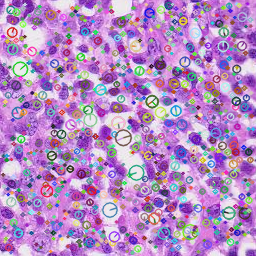

In [ ]:
# SIFT로 특징점 및 디스크립터 추출(desc_sift.py)

import cv2
import numpy as np

img = cv2.imread('/content/domain0_052.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# SIFT 추출기 생성
sift = cv2.xfeatures2d.SIFT_create()
# 키 포인트 검출과 서술자 계산
keypoints, descriptor = sift.detectAndCompute(gray, None)
print('keypoint:',len(keypoints), 'descriptor:', descriptor.shape)
print(descriptor)

# 키 포인트 그리기
img_draw = cv2.drawKeypoints(img, keypoints, None, \
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# 결과 출력
cv2_imshow(img_draw)

Origin


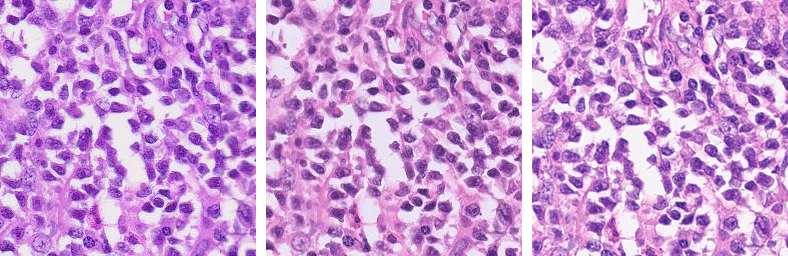

Result


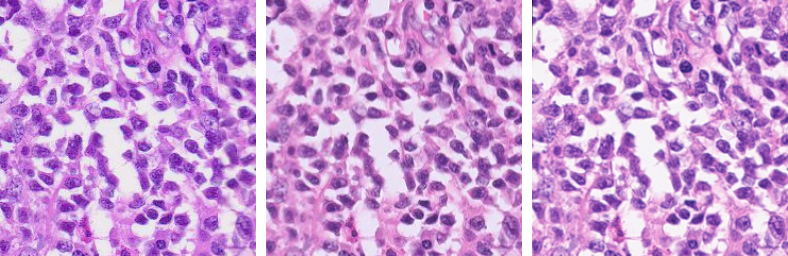

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


# 이미지 불러오기
img1 = cv2.imread('/content/domain0_052.png')  # 기준 이미지
img2 = cv2.imread('/content/domain1_052.png')  # 정렬할 이미지
img3 = cv2.imread('/content/domain2_052.png')  # 정렬할 이미지


# SIFT 탐지기 생성
sift = cv2.SIFT_create()

# 키포인트와 디스크립터 계산
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
keypoints3, descriptors3 = sift.detectAndCompute(img3, None)

# Brute Force 매처 생성
bf = cv2.BFMatcher()

# 첫 번째 이미지와 다른 이미지들 간의 매칭
matches12 = bf.knnMatch(descriptors1, descriptors2, k=2)
matches13 = bf.knnMatch(descriptors1, descriptors3, k=2)

# 좋은 매칭점만 선택 (비율 테스트 적용)
good_matches12 = [m for m, n in matches12 if m.distance < 0.75 * n.distance]
good_matches13 = [m for m, n in matches13 if m.distance < 0.75 * n.distance]

# 매칭된 키포인트 추출
src_pts12 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches12]).reshape(-1, 1, 2)
dst_pts12 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches12]).reshape(-1, 1, 2)

src_pts13 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches13]).reshape(-1, 1, 2)
dst_pts13 = np.float32([keypoints3[m.trainIdx].pt for m in good_matches13]).reshape(-1, 1, 2)

# Homography 계산 (RANSAC 사용)
M12, mask12 = cv2.findHomography(dst_pts12, src_pts12, cv2.RANSAC, 5.0)
M13, mask13 = cv2.findHomography(dst_pts13, src_pts13, cv2.RANSAC, 5.0)

# 이미지를 변환하여 정렬
height, width, channels = img1.shape
aligned_img2 = cv2.warpPerspective(img2, M12, (width, height))
aligned_img3 = cv2.warpPerspective(img3, M13, (width, height))

# 공통 영역을 추출하기 위해 세 이미지의 논리 AND 연산
aligned_img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
aligned_img2_gray = cv2.cvtColor(aligned_img2, cv2.COLOR_BGR2GRAY)
aligned_img3_gray = cv2.cvtColor(aligned_img3, cv2.COLOR_BGR2GRAY)

# 임계값 적용하여 흑백 마스크 생성 (빈 픽셀을 제외한 부분만 사용)
_, mask1 = cv2.threshold(aligned_img1_gray, 1, 255, cv2.THRESH_BINARY)
_, mask2 = cv2.threshold(aligned_img2_gray, 1, 255, cv2.THRESH_BINARY)
_, mask3 = cv2.threshold(aligned_img3_gray, 1, 255, cv2.THRESH_BINARY)

# 공통 영역을 논리 AND 연산으로 계산 (마스크된 부분 제거)
common_mask = cv2.bitwise_and(mask1, mask2)
common_mask = cv2.bitwise_and(common_mask, mask3)

# 공통된 부분의 바깥 경계를 확장하지 않도록 커널 크기 축소
# 경계 확장 없이 마스크 내부 영역만 사용
kernel = np.ones((3, 3), np.uint8)  # 작은 커널 크기 사용
common_mask = cv2.erode(common_mask, kernel, iterations=2)  # 내부로 확장


# 공통 영역의 바운딩 박스 계산
x, y, w, h = cv2.boundingRect(common_mask)

# 정사각형 크롭: 너비와 높이 중 작은 값을 기준으로 정사각형 크롭
crop_size = min(w, h)

# 바운딩 박스의 중앙을 기준으로 정사각형으로 크롭
x_center = x + w // 2
y_center = y + h // 2

# 정사각형 크롭을 위한 좌표 계산
x_square = x_center - crop_size // 2
y_square = y_center - crop_size // 2


# 각 이미지에서 정사각형 크롭
cropped_img1 = img1[y_square:y_square+crop_size, x_square:x_square+crop_size]
cropped_img2 = aligned_img2[y_square:y_square+crop_size, x_square:x_square+crop_size]
cropped_img3 = aligned_img3[y_square:y_square+crop_size, x_square:x_square+crop_size]

# 크롭된 이미지를 256x256 크기로 리사이즈
resized_img1 = cv2.resize(cropped_img1, (256, 256))
resized_img2 = cv2.resize(cropped_img2, (256, 256))
resized_img3 = cv2.resize(cropped_img3, (256, 256))


# 결과 출력
#cv2_imshow(resized_img1)  # 'Resized Image 1'
#cv2_imshow(resized_img2)  # 'Resized Image 2'
#cv2_imshow(resized_img3)  # 'Resized Image 3'

padding2 = add_padding([img1, img2, img3])
combined_resized2 = cv2.hconcat(padding2)
print("Origin")
cv2_imshow(combined_resized2)

padding = add_padding([resized_img1, resized_img2, resized_img3])
combined_resized = cv2.hconcat(padding)
print("Result")
cv2_imshow(combined_resized)